In [6]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3
import geopandas as gpd
import pandas as pd
from h3 import h3

# 0. Connect to Mongo and define a specific database

In [7]:
db=commu.connecttoLocaldb(database='Twitter_Data')

# 1. Obtaining hexcounts from database

In [8]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)

2.2770066261291504


In [9]:
df.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time
0,89be08182dbffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30
1,89be08184cbffff,1380499200000,1.0,1.0,NaN,1.0,2013-09-30
2,89be08186d3ffff,1419984000000,2.0,2.0,NaN,2.0,2014-12-31
3,89be08191bbffff,1435622400000,2.0,2.0,NaN,2.0,2015-06-30
4,89be081920fffff,1356912000000,3.0,3.0,NaN,3.0,2012-12-31


# 2. Divide the sample time period in two and compute time changes

We will divide the period available time period in two, average the counts for the two resulting subperiods, and compute the changes between periods. The result is a dataframe at the hex_id level. The result is also a GeoDataFrame ready to plot

In [10]:
# Tweets are counted in time intervals defined in the tweets counts function. The default is quarterly data. 
# 1. Check first the available dates in the counts
df.time.unique()

array(['2014-06-30T00:00:00.000000000', '2013-09-30T00:00:00.000000000',
       '2014-12-31T00:00:00.000000000', '2015-06-30T00:00:00.000000000',
       '2012-12-31T00:00:00.000000000', '2013-03-31T00:00:00.000000000',
       '2012-09-30T00:00:00.000000000', '2014-09-30T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2015-03-31T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2013-06-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000',
       '2013-12-31T00:00:00.000000000', '2014-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [11]:
# 2 Define a midpoint date to separate the two periods in the data. 
import datetime
gdfchanges=a.percent_change_two_periods_df(df, datebeforeandafterperiod=datetime.datetime(2013,6,30))

..\analysis.py:961: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2dif=df2.groupby('_id')['nonresidents', 'nonresidentsandnonneighbors', 'residents', 'totalcounts'].diff(1)


Coding \ _p0 is the average level of tweets counts in the first period \ _dif is the difference between periods \ _ch stands for % changes \ _chb is an alternative % change only for those hexs with more than 50 tweets.

In [12]:
gdfchanges.head(10)

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,nonresidentsandnonneighbors_ch,residents_ch,totalcounts_ch,nonresidents_chb,nonresidentsandnonneighbors_chb,residents_chb,totalcounts_chb,geometry
0,89be081a047ffff,-32.000000,-32.000000,NaN,-32.000000,32.500000,32.500000,NaN,32.500000,-0.984615,-0.984615,NaN,-0.984615,NaN,NaN,NaN,NaN,"POLYGON ((150.66192 -34.05922, 150.66143 -34.0..."
1,89be081a08bffff,-1.375000,-1.375000,NaN,-1.375000,2.000000,2.000000,NaN,2.000000,-0.687500,-0.687500,NaN,-0.687500,NaN,NaN,NaN,NaN,"POLYGON ((150.66486 -34.07088, 150.66437 -34.0..."
2,89be081a213ffff,0.214286,0.214286,NaN,1.125000,0.500000,0.500000,NaN,0.500000,0.428571,0.428571,NaN,2.250000,NaN,NaN,NaN,NaN,"POLYGON ((150.67117 -34.04544, 150.67068 -34.0..."
3,89be081a21bffff,-0.083333,-0.083333,NaN,-0.083333,0.333333,0.333333,NaN,0.333333,-0.250000,-0.250000,NaN,-0.250000,NaN,NaN,NaN,NaN,"POLYGON ((150.67246 -34.04217, 150.67198 -34.0..."
4,89be081a28bffff,1.714286,1.714286,NaN,1.714286,1.000000,1.000000,NaN,1.000000,1.714286,1.714286,NaN,1.714286,NaN,NaN,NaN,NaN,"POLYGON ((150.67393 -34.04800, 150.67344 -34.0..."
5,89be081a2c7ffff,NaN,NaN,NaN,0.416667,1.000000,1.000000,NaN,0.250000,NaN,NaN,NaN,1.666667,NaN,NaN,NaN,NaN,"POLYGON ((150.67523 -34.04474, 150.67474 -34.0..."
6,89be081a2d7ffff,2.555556,2.555556,NaN,2.555556,2.333333,2.333333,NaN,2.333333,1.095238,1.095238,NaN,1.095238,NaN,NaN,NaN,NaN,"POLYGON ((150.67799 -34.04730, 150.67750 -34.0..."
7,89be081a40bffff,-1.547619,-1.547619,NaN,-1.547619,2.333333,2.333333,NaN,2.333333,-0.663265,-0.663265,NaN,-0.663265,NaN,NaN,NaN,NaN,"POLYGON ((150.67998 -34.08044, 150.67949 -34.0..."
8,89be081a44fffff,0.166667,0.166667,NaN,0.166667,0.333333,0.333333,NaN,0.333333,0.500000,0.500000,NaN,0.500000,NaN,NaN,NaN,NaN,"POLYGON ((150.68257 -34.07390, 150.68208 -34.0..."
9,89be081a45bffff,-2.500000,-2.500000,NaN,-2.500000,3.000000,3.000000,NaN,3.000000,-0.833333,-0.833333,NaN,-0.833333,NaN,NaN,NaN,NaN,"POLYGON ((150.68939 -34.07576, 150.68890 -34.0..."


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

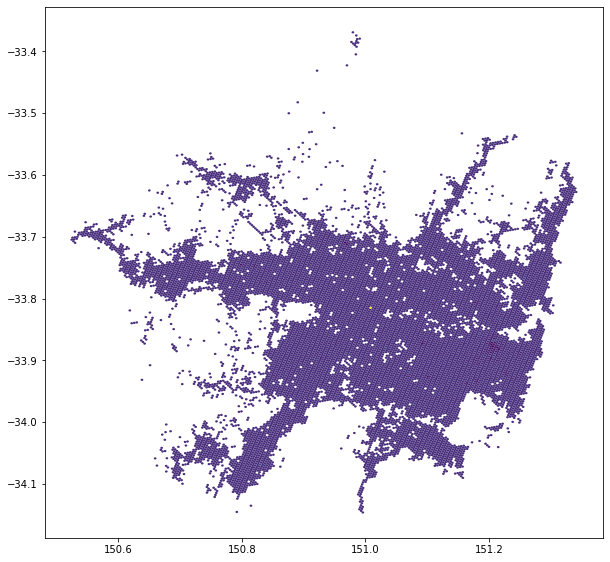

In [13]:
# Plot example
gdfchanges.plot('nonresidents_dif')
gdfchanges.crs

## 3. Spatial join with census tracks (typologies) data

This requires:

    An available function changes the geometry of the gdf to the centroids
    Load your typologies data to a geodataframe
    Spatial join

In [14]:
#1 Get centroids
gdfchanges_points = myh3.df_with_hexid_to_centroids_gdf(gdfchanges, hexcolname='_id')

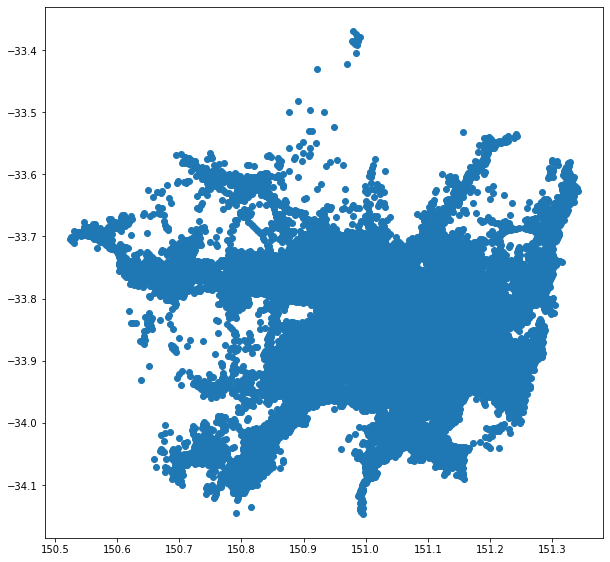

In [15]:
gdfchanges_points.plot()

In [16]:
# Load your typologies data as a geodataframe 
from pathlib import Path, PureWindowsPath
shp_path = Path("../../../../Box/Twitter data/Observation Shapefiles")

tracts = gpd.read_file(shp_path/"syd.geojson")
tracts = tracts.to_crs({'init': 'epsg:4326'})

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

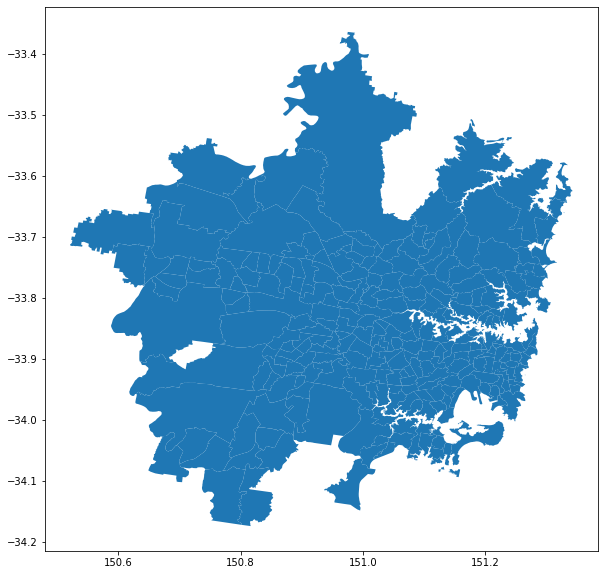

In [17]:
tracts.plot()
tracts.crs

In [18]:
# # 3 Spatial Join between centroids and census track shapes
tweets_tracts=gpd.sjoin(gdfchanges_points, tracts, how="inner", op='intersects')

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != +init=epsg:4326 +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [19]:
tweets_tracts.head()

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,...,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,OID,SA2_MAINCODE_2016,rentals_ov100_11,types,Typology_ID,standardized_types
0,89be081a047ffff,-32.000000,-32.000000,NaN,-32.000000,32.500000,32.500000,NaN,32.500000,-0.984615,...,Greater Sydney,1,New South Wales,26.1934,156,123011433,1,-1,HI - Stable Exclusion,Exclusive Static
1,89be081a08bffff,-1.375000,-1.375000,NaN,-1.375000,2.000000,2.000000,NaN,2.000000,-0.687500,...,Greater Sydney,1,New South Wales,26.1934,156,123011433,1,-1,HI - Stable Exclusion,Exclusive Static
2,89be081a213ffff,0.214286,0.214286,NaN,1.125000,0.500000,0.500000,NaN,0.500000,0.428571,...,Greater Sydney,1,New South Wales,26.1934,156,123011433,1,-1,HI - Stable Exclusion,Exclusive Static
3,89be081a21bffff,-0.083333,-0.083333,NaN,-0.083333,0.333333,0.333333,NaN,0.333333,-0.250000,...,Greater Sydney,1,New South Wales,26.1934,156,123011433,1,-1,HI - Stable Exclusion,Exclusive Static
4,89be081a28bffff,1.714286,1.714286,NaN,1.714286,1.000000,1.000000,NaN,1.000000,1.714286,...,Greater Sydney,1,New South Wales,26.1934,156,123011433,1,-1,HI - Stable Exclusion,Exclusive Static


In [20]:
typo_stats = tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem'])
#nonresidents_p0
typo_stats

nonresidents_dif                  \
                                          mean count       sem   
standardized_types                                               
Exclusive Dynamic                    -4.196031  2895  0.969689   
Exclusive Static                     -3.219146  3846  0.916229   
Low Income, At Risk of Change        -5.472194  2354  4.236825   
Low Income, Stable                   -2.725788  1630  0.938391   
Low Income, Undergoing Change        -4.024715  2238  1.155947   

                              nonresidents_ch                 nonresidents_p0  \
                                         mean count       sem            mean   
standardized_types                                                              
Exclusive Dynamic                    1.592631  2895  0.245846       25.442949   
Exclusive Static                     1.868212  3846  0.162788       23.627544   
Low Income, At Risk of Change        1.743219  2354  0.221161       48.529029   
Low Income, Stable                   2.011746  1630  0.277620       12.681193   
Low Income, Undergoing Change        1.860478  2238  0.250806       20.432894   

                                               
                              count       sem  
standardized_types                             
Exclusive Dynamic              2898  1.953704  
Exclusive Static               3849  1.384341  
Low Income, At Risk of Change  2354  4.946121  
Low Income, Stable             1635  0.899151  
Low Income, Undergoing Change  2239  1.265296

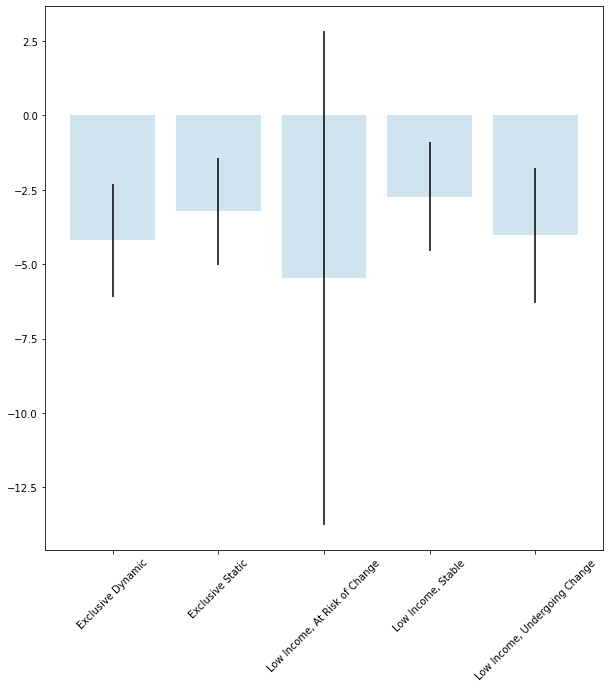

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(typo_stats.index, typo_stats['nonresidents_dif','mean'], yerr=1.96*typo_stats['nonresidents_dif','sem'], alpha=0.2)
plt.xticks(rotation=45)
plt.show()

In [22]:
import matplotlib.pyplot as plt

def barchart(tweets_tracts, metric, title):
    
    #Windsorizing series to tream outliers 
    tweets_tracts['nonresidents_dif']=tweets_tracts['nonresidents_dif'].clip(lower= -60, upper=1000)
    tweets_tracts['nonresidents_ch']=tweets_tracts['nonresidents_ch'].clip(upper=6)
    
    #tweets_tracts['nonresidents_ch'].hist()
    typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem','std'])
    
    typo_stats=typo_stats.reset_index()
    
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON_POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='OTHER']
    
    
    #Sorting 
    typo_stats=typo_stats.sort_values(by=(metric,'mean'), ascending=False)
    
    fig, ax = plt.subplots()
    ax.bar(typo_stats['standardized_types'], typo_stats[metric,'mean'], yerr=1.96*typo_stats[metric,'sem'], alpha=0.2)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

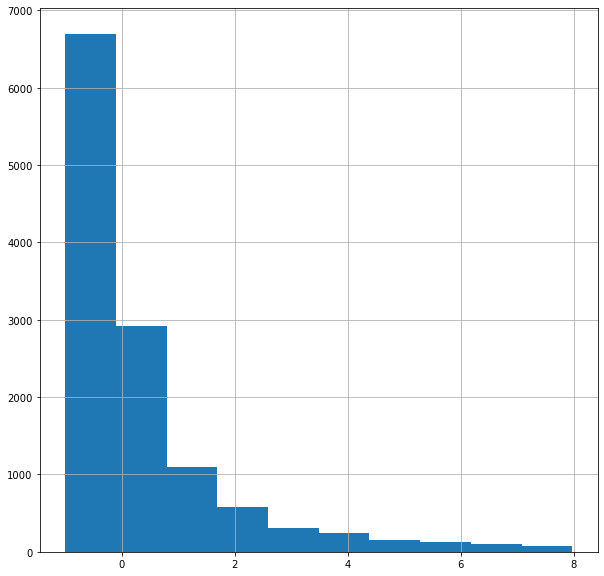

In [23]:
tweets_tracts.loc[tweets_tracts.nonresidents_ch<8].nonresidents_ch.hist()

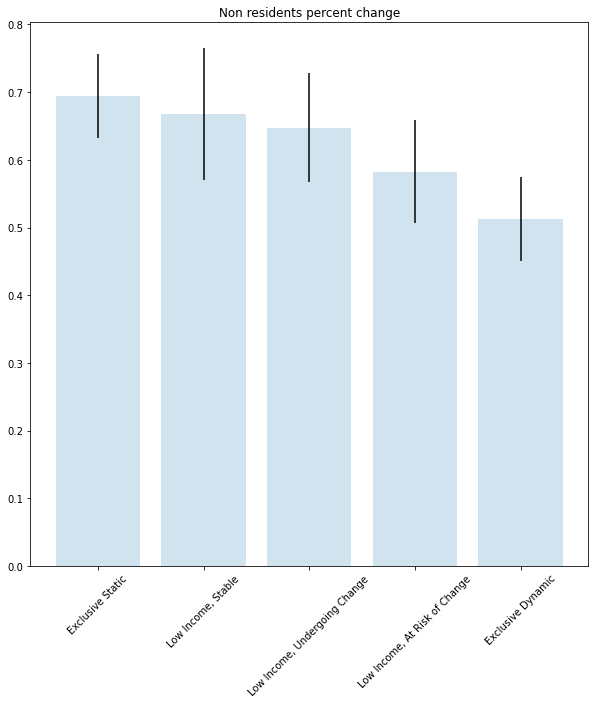

In [24]:
barchart(tweets_tracts, 'nonresidents_ch', title="Non residents percent change")

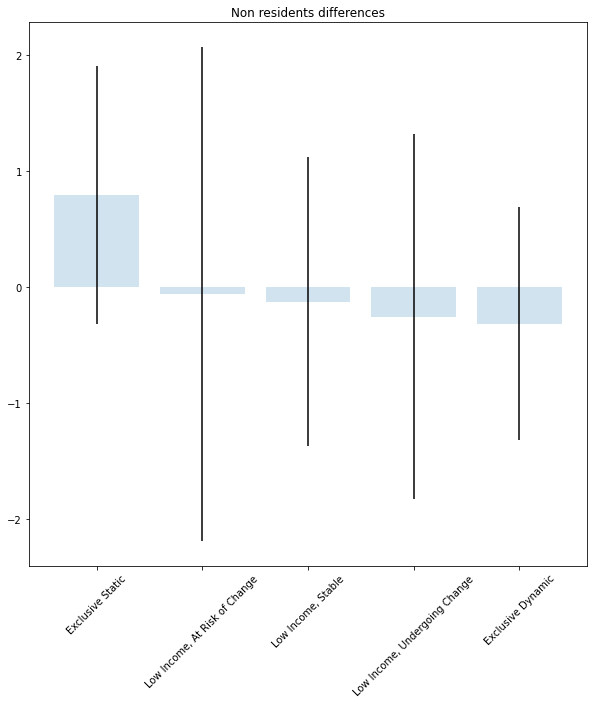

In [25]:
barchart(tweets_tracts, 'nonresidents_dif', title="Non residents differences")